In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [13]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement).order_by(measurement.date.desc()).first()
recent_date = dt.datetime.strptime(most_recent_date.date, '%Y-%m-%d').date() 
recent_date



datetime.date(2017, 8, 23)

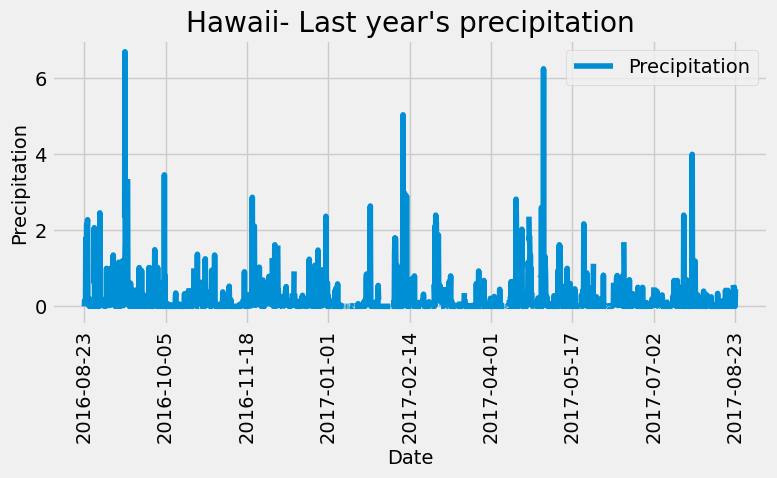

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)
#year_ago

# Perform a query to retrieve the data and precipitation scores
preci_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date>=year_ago).order_by(measurement.date).all()
#preci_scores

# Save the query results as a Pandas DataFrame. Explicitly set the column names
preci_df = pd.DataFrame(preci_scores, columns=['date', 'prcp'])
preci_df = preci_df.rename(columns={'date': "Date", 'prcp': "Precipitation"})
#preci_df

# Sort the dataframe by date
sorted_df = preci_df.sort_values("Date")
sorted_df = sorted_df.set_index("Date")
sorted_df

# Use Pandas Plotting with Matplotlib to plot the data
image1 = sorted_df.plot(figsize=(8,5), title = "Hawaii- Last year's precipitation",\
     xlabel = "Date", ylabel="Precipitation")
x_ticks = np.linspace(0, len(sorted_df)-1, 9, dtype=int)
plt.xticks(x_ticks, sorted_df.index[x_ticks], rotation='vertical')
plt.ylim(-.5, 7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
image1.figure.savefig('2016-2017_Hawaii_Precipitation.png', bbox_inches='tight')

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).count()
total_stations


9

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).group_by(measurement.station).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station,func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).first()
MAS = most_active_station[0]
#MAS
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == MAS).first()
#lowest_temp
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == MAS).first()
#highest_temp
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == MAS).first()
#avg_temp
print(f"From ID {MAS}, the lowest temperature is {lowest_temp}, the highest temperature is {highest_temp} and the average temperature is {avg_temp}.")


From ID USC00519281, the lowest temperature is (54.0,), the highest temperature is (85.0,) and the average temperature is (71.66378066378067,).


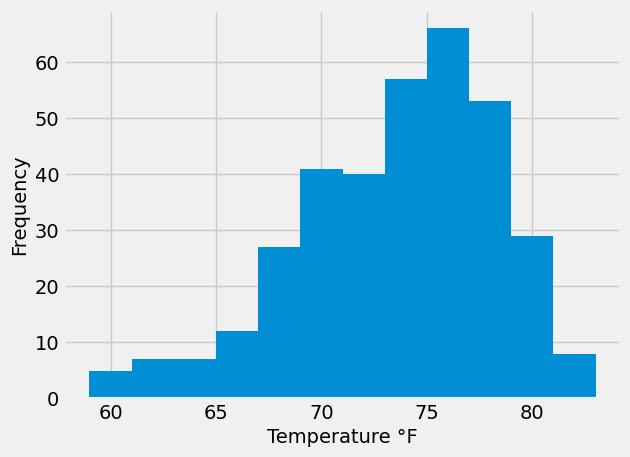

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearly_id = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == MAS).\
    filter(measurement.date >= year_ago).all()
#yearly_id

#Create data frame
yid_df = pd.DataFrame(yearly_id, columns = ['date', 'tobs'])
yid_df = yid_df.rename(columns={'date': "Date", 'tobs': "Temperature"})

# Sort the dataframe by date
yid_df = yid_df.sort_values("Date")
yid_df = yid_df.set_index("Date")
yid_df.head()

#Plot
plt.hist(yid_df["Temperature"], bins = 12, label= "TOBS")
plt.xlabel ("Temperature °F")
plt.ylabel ("Frequency")
plt.show()


# Close Session

In [23]:
# Close Session
session.close()